### If you have any suggestions, or find bugs, create a jira ticket:
https://bbpteam.epfl.ch/project/issues/projects/ACCS/issues/?filter=allopenissues

We begin by loading a circuit

In [8]:
import pandas
import numpy
import bluepy

circ_fn = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TC_WM"
column_prop_fn = "/gpfs/bbp.cscs.ch/project/proj83/home/reimann/subvolumes/voxel-based-hex-grid-info-with-conicality.h5"

circ = bluepy.Circuit(circ_fn)
col_props = pandas.read_hdf(column_prop_fn, "grid-info")

New we load basic information about neurons into a DataFrame.
To that end, we first write a "loader_config". It specifies the following:
 - Which neurons to load and which of their properties
 - Which filter to apply. In this example, we focus on layer 4 connectivity only
 - How to group the neurons into different classes. Here, we group the neurons together into 400 um "columns", i.e. according to a hexagonal grid
 
 Feel free to adjust any of the specifics, for example using smaller columns

In [9]:
# install the following repo from: bbpgitlab.epfl.ch:conn/structural/Connectome-utilities.git
# Note: There is more documentation in that repo!
from conntility.circuit_models import neuron_groups

loader_config = {
    "loading": {
        "base_target": "Mosaic", 
        "properties": ["x", "y", "z", "etype", "mtype", "layer", "synapse_class"],
        "atlas": [
            {"data": "/gpfs/bbp.cscs.ch/project/proj83/home/reimann/subvolumes/column_identities.nrrd",
             "properties": ["column_id"]}
        ]
    },
    "filtering":[
        {
            "column": "layer",
            "value": 4
        }
    ],
    "grouping": [
        {
            "method": "group_by_properties",
            "columns": ["column_id"]
        }
    ]
}


base_grp = neuron_groups.load_group_filter(circ, loader_config)

display(base_grp)
# NOTE: column_id 0 indicates a neuron is NOT MEMBER OF ANY COLUMN!

,etype,layer,mtype,synapse_class,x,y,z,gid,column_id
idx-column_id,,,,,,,,,
0,cADpyr,4,L4_TPC,EXC,3268.886432,-2218.224359,-1737.954129,2527282,0
0,cADpyr,4,L4_TPC,EXC,3849.881414,-3466.198107,-2750.492024,2527316,0
0,cADpyr,4,L4_TPC,EXC,3239.995047,-2220.746300,-1719.661074,2527331,0
0,cADpyr,4,L4_TPC,EXC,3243.908223,-2168.676812,-1732.133370,2527365,0
0,cADpyr,4,L4_TPC,EXC,4087.109544,-3359.881557,-3791.233055,2527382,0
...,...,...,...,...,...,...,...,...,...
237,cADpyr,4,L4_TPC,EXC,6260.139475,1894.998384,-4680.608800,2615239,237
237,cNAC,4,L4_NBC,INH,6168.881613,1895.761837,-4738.744205,2793529,237
237,cADpyr,4,L4_TPC,EXC,6170.364446,1890.751772,-4743.937984,2520607,237


Quick check: How many neurons of each type are we considering?

As expected: Only layer 4 neurons, but all of them.

In [7]:
base_grp["mtype"].value_counts()

L4_TPC       408232
L4_UPC       169797
L4_SSC        57803
L4_LBC        12943
L4_MC          9831
L4_NBC         8817
L4_BTC         5195
L4_BP          1870
L4_SBC         1749
L4_DBC         1746
L4_NGC         1052
L4_CHC          386
L5_TPC:B          0
L5_SBC            0
L5_NGC            0
L5_NBC            0
L5_TPC:A          0
L5_TPC:C          0
L5_LBC            0
L6_LBC            0
L6_TPC:C          0
L6_TPC:A          0
L6_SBC            0
L6_NGC            0
L6_NBC            0
L6_MC             0
L6_IPC            0
L5_UPC            0
L6_HPC            0
L6_DBC            0
L6_CHC            0
L6_BTC            0
L6_BPC            0
L6_BP             0
L5_MC             0
L1_DAC            0
L5_DBC            0
L5_CHC            0
L1_LAC            0
L1_NGC-DA         0
L1_NGC-SA         0
L1_SAC            0
L23_BP            0
L23_BTC           0
L23_CHC           0
L23_DBC           0
L23_LBC           0
L23_MC            0
L23_NBC           0
L23_NGC           0


We use the following to load the matrix of connections _between_ the defined groups.
(Note: There are different functions available for loading connections within groups).

Here, we load the midrange connection count. Use instead "local" for location connectivity.

In [20]:
from conntility import circuit_models

M = circuit_models.circuit_matrix_between_groups(circ, base_grp, connectome="intra_SSCX_midrange_wm",
                                                 extract_full=True)

Counting...: 100%|██████████| 82/82 [11:04<00:00,  8.10s/it]


The result is a pandas.Series with connection counts between groups. Indexed by the name of the source / target groups.

In [40]:
valid = M.index.to_frame().applymap(lambda x: int(x) > 0).all(axis=1) # remove entries not associated with a column (0)
M = M.loc[valid]
display(M)

Source node  Target node
1            15                20.0
             19                 1.0
             2                 22.0
             3                102.0
             4               5389.0
                             ...   
99           90              5608.0
             96                 1.0
             97             45790.0
             98                 8.0
             99                31.0
Length: 10595, dtype: float64

Let plot the connectivity matrix

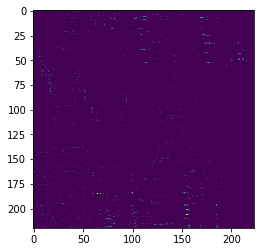

In [41]:
from matplotlib import pyplot as plt

plt.imshow(M.unstack("Target node", fill_value=0), interpolation="nearest")

For further analysis, we need to know the locations of each of the groups. So we quickly assembly a frame of the flat x and y locations of each group, index by the same strings as "M".

In [42]:
hex_locations = col_props[["grid-x", "grid-y"]]

display(hex_locations)

,grid-x,grid-y
0,3.802528e-13,6210.0
1,1.991858e+02,6555.0
2,3.983717e+02,6210.0
3,5.975575e+02,6555.0
4,3.380025e-13,5520.0
...,...,...
235,4.780460e+03,1380.0
236,6.174761e+03,3105.0
237,5.378018e+03,5175.0
238,4.581274e+03,1035.0


Unstacking and re-stacking the data leads to filling in "0" values for all combinations that are unlisted 

In [43]:
M = M.unstack("Target node", fill_value=0).stack()

Now we can plot for example the strengths of connections from an exemplary location
NOTE: This is long-range connectivity only, so we do not expect it to peak around the source location

<ipython-input-60-4727c33f94d2>:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, value in m.iteritems():


Text(0, 0.5, 'um')

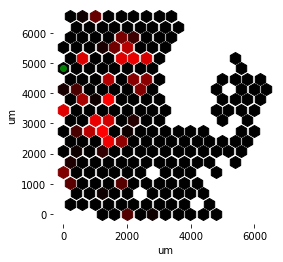

In [60]:
exemplary_col = "10"
exemplary_loc = hex_locations.loc[int(exemplary_col)]
plot_divider = 5

# Submatrix
m = M.loc[exemplary_col]
m.name = "C"
m.index = m.index.to_frame().astype(int)["Target node"] # BEcause one is indexed by int, the other by str :(
# Concatenate the connectivity data with the x, y corresponding locations of target groups.
# Than set the index to the locations
m = pandas.concat([m, hex_locations.loc[m.index]], axis=1).set_index(["grid-x", "grid-y"], drop=True)["C"]

# Plot log-scale
ax = plt.figure(figsize=(4, 4)).gca()
for loc, value in m.iteritems():
    col = [numpy.minimum(numpy.log10(value + 1) / plot_divider, 1), 0, 0]
    ax.plot(loc[0], loc[1], marker="h", color=col, ms=12)

ax.plot(exemplary_loc["grid-x"], exemplary_loc["grid-y"], marker='o', color="green")
ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")

Neat! Even cooler: Both outgoing and incoming connectivity.
We encode outgoing strength in the "red" channel, incoming in the "blue" channel.

Text(0, 0.5, 'um')

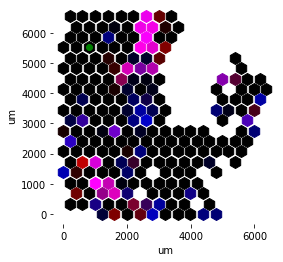

In [65]:
exemplary_col = "20"
exemplary_loc = hex_locations.loc[int(exemplary_col)]
plot_divider = 5

# Submatrices
m_outgoing = M.loc[exemplary_col]
m_outgoing.name = "OUT"
m_outgoing.index = m_outgoing.index.to_frame().astype(int)["Target node"]

m_incoming = M.loc[:, exemplary_col]
m_incoming.name = "IN"
m_incoming.index = m_incoming.index.to_frame().astype(int)["Source node"]

# Concatenate the connectivity data with the x, y corresponding locations of target groups.
# Than set the index to the locations
m = pandas.concat([m_outgoing, m_incoming], axis=1)               
m = pandas.concat([m, hex_locations.loc[m_outgoing.index]], axis=1).set_index(["grid-x", "grid-y"], drop=True)

# Plot log-scale
ax = plt.figure(figsize=(4, 4)).gca()
for loc, values in m.iterrows():
    col = [numpy.minimum(numpy.log10(values["OUT"] + 1) / plot_divider, 1),
           0,
           numpy.minimum(numpy.log10(values["IN"] + 1) / plot_divider, 1)]
    ax.plot(loc[0], loc[1], marker="h", color=col, ms=12)

ax.plot(exemplary_loc["grid-x"], exemplary_loc["grid-y"], marker='o', color="green")
ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")

Another example: Total incoming strength.

Note: Not using logarithmic color scale, unlike above

<ipython-input-69-c91d995b9cc4>:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, value in m.iteritems():


Text(0, 0.5, 'um')

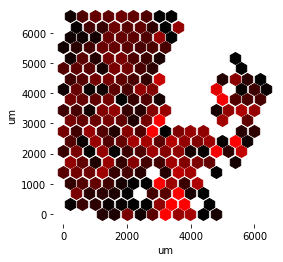

In [69]:
plot_divider = 2E6
# Matrix of sum of incoming connections
m = M.groupby("Target node").agg("sum")
m.name = "C"
m.index = m.index.to_frame().astype(int)["Target node"]

# Concatenate the connectivity data with the x, y corresponding locations of target groups.
# Than set the index to the locations
m = pandas.concat([m, hex_locations.loc[m.index]], axis=1).set_index(["grid-x", "grid-y"], drop=True)["C"]

# Plot log-scale
ax = plt.figure(figsize=(4, 4)).gca()
for loc, value in m.iteritems():
    col = [numpy.minimum(value / plot_divider, 1), 0, 0]
    ax.plot(loc[0], loc[1], marker="h", color=col, ms=12)

ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")

Or outgoing

<ipython-input-73-068a03216e08>:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, value in m.iteritems():


Text(0, 0.5, 'um')

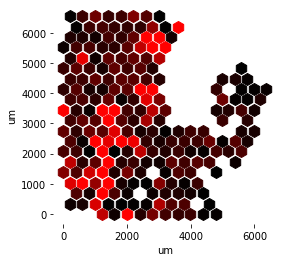

In [73]:
plot_divider = 2E6
# Matrix of sum of outgoing connections
m = M.groupby("Source node").agg("sum")
m.name = "C"
m.index = m.index.to_frame().astype(int)["Source node"]

# Concatenate the connectivity data with the x, y corresponding locations of target groups.
# Than set the index to the locations
m = pandas.concat([m, hex_locations.loc[m.index]], axis=1).set_index(["grid-x", "grid-y"], drop=True)["C"]

# Plot log-scale
ax = plt.figure(figsize=(4, 4)).gca()
for loc, value in m.iteritems():
    col = [numpy.minimum(value / plot_divider, 1.0), 0, 0]
    ax.plot(loc[0], loc[1], marker="h", color=col, ms=12)

ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")